In [160]:
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import matplotlib.pyplot as plt
import importlib
from common import common
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [161]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/suyeetan/Downloads/CS5344_Project/work/common/common.py'>

In [162]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TEST_COUNT = 1500

In [163]:
%run datasets/covertype.ipynb
# %run datasets/kdd.ipynb
# %run datasets/cicids.ipynb
# %run datasets/unsw.ipynb
# %run datasets/thyroid.ipynb

In [164]:
# Should already be one hot encoded and label encoded
all_df, main_labels, config = get_processed_covtype_df()
# all_df, main_labels, config = get_processed_kdd_df()
# all_df, main_labels, config = get_processed_cicids_df()
# all_df, main_labels, config = get_processed_unsw_df()
# all_df, main_labels, config = get_processed_thyroid_df()
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

Normal class:  0    2
Name: Cover_Type, dtype: int32


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [165]:
all_df.shape

(581012, 55)

In [166]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [167]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [168]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(464809, 54) (116203, 54) (464809,) (116203,)


In [169]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
519924,3289.0,22.0,19.0,240.0,93.0,1708.0,205.0,196.0,122.0,2598.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
318451,2963.0,21.0,18.0,134.0,27.0,1243.0,206.0,200.0,127.0,1140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
22325,3037.0,185.0,9.0,127.0,10.0,6462.0,222.0,246.0,158.0,3037.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
449376,3113.0,203.0,13.0,190.0,22.0,2125.0,213.0,251.0,171.0,730.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
482753,3128.0,346.0,9.0,120.0,36.0,552.0,203.0,226.0,161.0,924.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [170]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [171]:
benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Parallel execution to create the anomaly datasets for each anomaly class
with ProcessPoolExecutor() as executor:
    futures = []
    for label, name in TARGET_DICT.items():
        if label == NORMAL_TARGET:
            continue  # Skip the normal target
        
        # Submit tasks to the executor
        futures.append(executor.submit(common.create_dataset_for_label, label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels))
    
    # Retrieve results (optional, here we're just ensuring completion)
    for future in futures:
        name = future.result()  # Ensures all tasks are done
        print(f"Dataset for {name} processed.")

print("All datasets created successfully!")

abnormal_type_dict {2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747}
Dataset for Spruce-Fir processed.
Dataset for PonderosaPine processed.
Dataset for CottonwoodWillow processed.
Dataset for Aspen processed.
Dataset for DouglasFir processed.
Dataset for Krummholz processed.
CottonwoodWillow.csv created with 8241 rows. (5494 benign and 2747 abnormal rows)
Aspen.csv created with 28479 rows. (18986 benign and 9493 abnormal rows)
DouglasFir.csv created with 52101 rows. (34734 benign and 17367 abnormal rows)
PonderosaPine.csv created with 107262 rows. (71508 benign and 35754 abnormal rows)
Krummholz.csv created with 61530 rows. (41020 benign and 20510 abnormal rows)
Spruce-Fir.csv created with 495141 rows. (283301 benign and 211840 abnormal rows)
All datasets created successfully!


In [172]:
# tdf = pd.read_csv('csv_files/smurf.csv')
# tdf['attack'].unique()
# len(main_labels)
all_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [ ]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
SVMs = {}

process_csv_with_args = partial(
        common.process_csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler 
    )

# Parallel execution to get the most important features of each csv
with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_csv_with_args, csv_files))

# Collect results from the futures
for label, important_features, svm, impor_bars, voting_clf in results:
    feature_importances[label] = important_features
    SVMs[label] = svm

    # Show feature importance
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

csv_files ['Krummholz.csv', 'CottonwoodWillow.csv', 'DouglasFir.csv', 'Aspen.csv', 'Spruce-Fir.csv', 'PonderosaPine.csv']


In [155]:
seconds = time.time()

# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_scaled_df, y_train_df)
knn.fit(X_train_df, y_train_df)

# Step 2: Predict classes for the test set
print('Cap testset with length ', len(X_test_df),' at ',TEST_COUNT)
X_test_df = X_test_df[:TEST_COUNT]
X_test_scaled_df = X_test_scaled_df[:TEST_COUNT]
y_test_df = y_test_df[:TEST_COUNT]

# knn_predictions = knn.predict(X_test_scaled)
knn_predictions = knn.predict(X_test_df)
print('knn_predictions', knn_predictions)

print("Total operation time: = ",time.time()- seconds ,"seconds")

Reduce testset from  1331  to  1500
knn_predictions [0 0 0 ... 0 0 0]
Total operation time: =  0.02243828773498535 seconds


-----KNN Evaluation-----


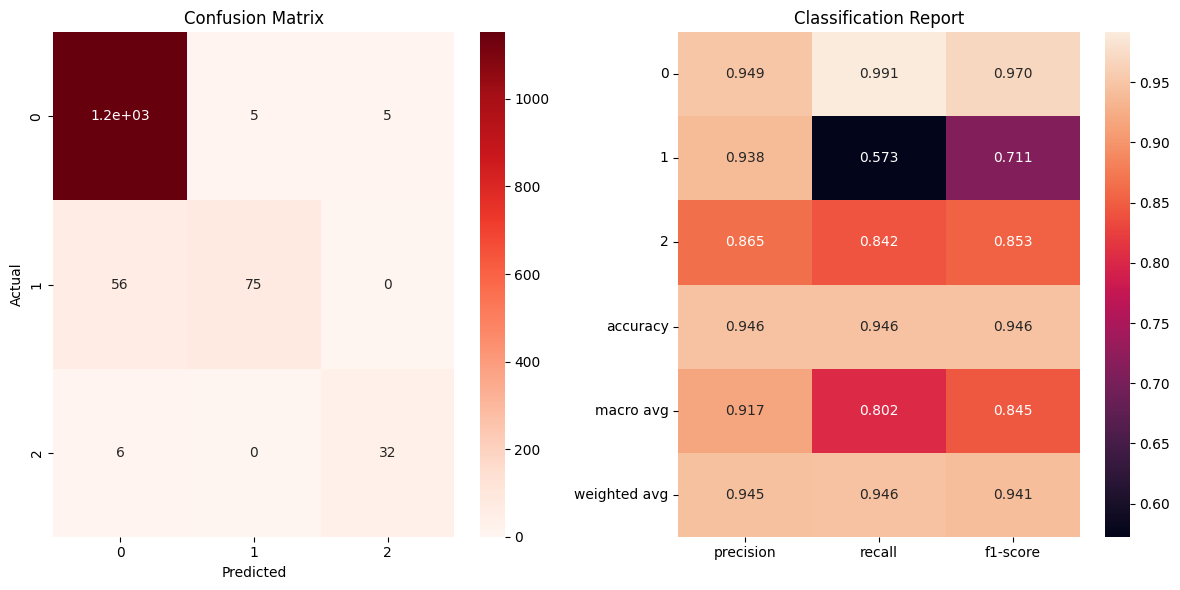

Accuracy: 0.9459053343350864


(array([[1152,    5,    5],
        [  56,   75,    0],
        [   6,    0,   32]]),
 {'0': {'precision': 0.9489291598023064,
   'recall': 0.9913941480206541,
   'f1-score': 0.9696969696969697,
   'support': 1162.0},
  '1': {'precision': 0.9375,
   'recall': 0.5725190839694656,
   'f1-score': 0.7109004739336493,
   'support': 131.0},
  '2': {'precision': 0.8648648648648649,
   'recall': 0.8421052631578947,
   'f1-score': 0.8533333333333334,
   'support': 38.0},
  'accuracy': 0.9459053343350864,
  'macro avg': {'precision': 0.9170980082223904,
   'recall': 0.8020061650493382,
   'f1-score': 0.8446435923213175,
   'support': 1331.0},
  'weighted avg': {'precision': 0.9454042438430841,
   'recall': 0.9459053343350864,
   'f1-score': 0.9409034617128877,
   'support': 1331.0}},
 0.9459053343350864)

In [156]:
common.evaluate(y_test_df, knn_predictions, heading='-----KNN Evaluation-----')

In [157]:
svm_predictions = []
seconds = time.time()

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    if knn_predictions[i] == NORMAL_TARGET:
        svm_predictions.append((0, NORMAL_TARGET, y_test_df.iloc[i]))
        continue
    predicted_label = TARGET_DICT[knn_predictions[i]]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    # Select features for the SVM
    test_instance_selected_df = test_instance_df[selected_features]
    svm_prediction = svm_model.predict(test_instance_selected_df)
    print('svm prediction: ', svm_prediction, 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test_df.iloc[i])
    svm_predictions.append((svm_prediction, INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print("Total operation time: = ",time.time()- seconds ,"seconds")

svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  0
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [1] knn prediction:  1 actual value:  0
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn predic

-----SVM Evaluation (for anomalies)-----


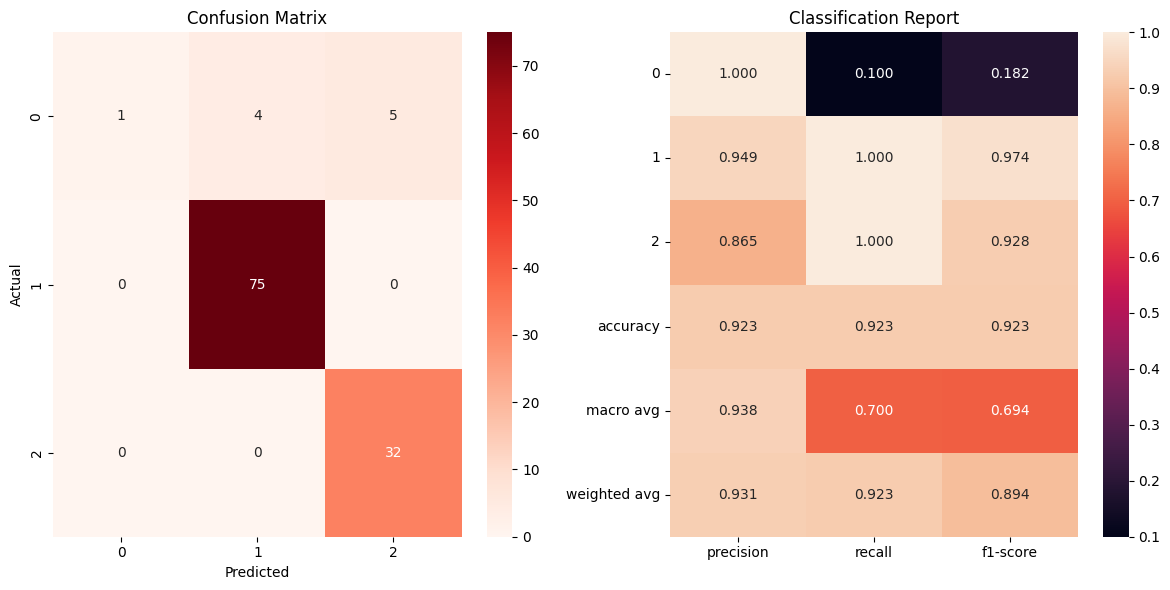

Accuracy: 0.9230769230769231


(array([[ 1,  4,  5],
        [ 0, 75,  0],
        [ 0,  0, 32]]),
 {'0': {'precision': 1.0,
   'recall': 0.1,
   'f1-score': 0.18181818181818182,
   'support': 10.0},
  '1': {'precision': 0.9493670886075949,
   'recall': 1.0,
   'f1-score': 0.974025974025974,
   'support': 75.0},
  '2': {'precision': 0.8648648648648649,
   'recall': 1.0,
   'f1-score': 0.927536231884058,
   'support': 32.0},
  'accuracy': 0.9230769230769231,
  'macro avg': {'precision': 0.9380773178241532,
   'recall': 0.7000000000000001,
   'f1-score': 0.694460129242738,
   'support': 117.0},
  'weighted avg': {'precision': 0.9305829685576521,
   'recall': 0.9230769230769231,
   'f1-score': 0.8936007631659805,
   'support': 117.0}},
 0.9230769230769231)

In [158]:
# Now evaluate SVM predictions only for the anomalies detected by KNN
# Create a mask for test instances that KNN classified as anomalies
anomaly_mask = knn_predictions != NORMAL_TARGET  # Assuming normal_target is your normal class
# print('anomaly_mask', len(anomaly_mask))

# Get true labels and predictions for anomalies
svm_predictions_actual = [knn if pred == 0 else NORMAL_TARGET for pred, knn, y_test in svm_predictions]
# print(svm_predictions_actual)
svm_predictions_actual_df = pd.DataFrame(svm_predictions_actual, columns=[TARGET_COLUMN])
y_test_anomalies_df = y_test_df[anomaly_mask]
svm_predictions_anomalies_df = svm_predictions_actual_df[anomaly_mask]
# print('Lengths: ', len(y_test_anomalies_df), len(svm_predictions_anomalies_df))

# Evaluate SVM only on the anomalies
common.evaluate(y_test_anomalies_df, svm_predictions_anomalies_df, heading='-----SVM Evaluation (for anomalies)-----')

SVM Evaluation (for all)


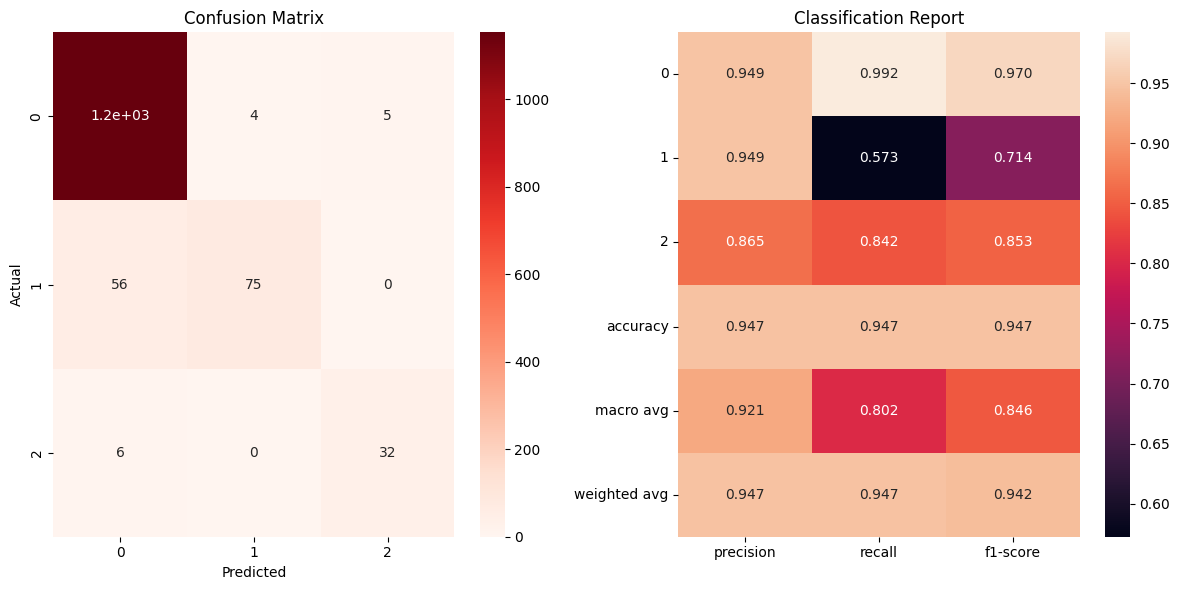

Accuracy: 0.946656649135988


(array([[1153,    4,    5],
        [  56,   75,    0],
        [   6,    0,   32]]),
 {'0': {'precision': 0.9489711934156378,
   'recall': 0.9922547332185886,
   'f1-score': 0.9701304164913757,
   'support': 1162.0},
  '1': {'precision': 0.9493670886075949,
   'recall': 0.5725190839694656,
   'f1-score': 0.7142857142857143,
   'support': 131.0},
  '2': {'precision': 0.8648648648648649,
   'recall': 0.8421052631578947,
   'f1-score': 0.8533333333333334,
   'support': 38.0},
  'accuracy': 0.946656649135988,
  'macro avg': {'precision': 0.9210677156293658,
   'recall': 0.802293026781983,
   'f1-score': 0.8459164880368077,
   'support': 1331.0},
  'weighted avg': {'precision': 0.946608925786199,
   'recall': 0.946656649135988,
   'f1-score': 0.941615055748365,
   'support': 1331.0}},
 0.946656649135988)

In [159]:
common.evaluate(y_test_df, svm_predictions_actual_df, heading='SVM Evaluation (for all)')